## Unet Implementation

### Download Data

In [1]:
import os

# Define the file path and extracted directory path
file_path = 'images.zip'
extracted_path = 'lgg-mri-segmentation/kaggle_3m'

# Check if the file already exists
if not os.path.exists(file_path):
    # Download the file if it doesn't exist
    !wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351' -O images.zip
else:
    print("File already exists. No need to download again.")

# Check if the directory already exists
if not os.path.exists(extracted_path):
    # Unzip the file if the directory doesn't exist
    !unzip -n images.zip -d lgg-mri-segmentation
    print("Unzip operation completed.")
else:
    print("Files are already extracted. No need to unzip again.")

# IMAGE_PATH variable
IMAGE_PATH = 'lgg-mri-segmentation/kaggle_3m'

# Your existing code for listing the paths
paths = []
for dirname in os.listdir(IMAGE_PATH):
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):
        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Only the files with ',tif' format should be added to the 'paths' list
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH+'/'+dirname+'/'+filename)

len(paths), paths[:20:5]


--2025-02-28 05:00:00--  https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.174.132, 2404:6800:4008:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.174.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748584920 (714M) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>] 713.91M  75.1MB/s    in 10s     

2025-02-28 05:00:13 (70.1 MB/s) - ‘images.zip’ saved [748584920/748584920]

Archive:  images.zip
  inflating: lgg-mri-segmentation/kaggle_3m/README.md  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  i

(7858,
 ['lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20_mask.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_7_mask.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18_mask.tif'])

### Data Preprocessing

In [2]:
## source https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
def data_frame(data):
    # Storing only paths that don't end with 'mask.tiff'
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Sorting images based on the number of each MRI.
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))

    # Storing the image IDs
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    # Storing only paths that end with 'mask.tiff'
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Sorting masks based on the number of each MRI.
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Opens the images
    pixels = lambda x: Image.open(x)
    # Selects the largest pixel
    largest_pixel = lambda y: np.max(pixels(y))
    # Determines if the mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Storing the diagnosis corresponding to each image
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    # Making the dataframe
    DataFrame = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})

    # Dividing the indexes into train, test, and validation
    train_index, test_index = train_test_split(DataFrame.index.values.tolist(), test_size=0.15, random_state=42)
    train_index, val_index = train_test_split(train_index, test_size=0.1, random_state=42)

    # Making train, test, and validation dataframes
    train_df, val_df, test_df = DataFrame.iloc[train_index], DataFrame.iloc[val_index], DataFrame.iloc[test_index]

    return train_df, val_df, test_df

# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

train_df.head()

3005 334 590


ID  \
472   TCGA_DU_6408_19860521_31   
288   TCGA_DU_6405_19851005_23   
3666  TCGA_FG_6691_20020405_29   
851   TCGA_DU_7018_19911220_36   
2796  TCGA_HT_A61B_19991127_11   

                                                  Image  \
472   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...   
288   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...   
3666  lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...   
851   lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...   
2796  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...   

                                                   Mask  Diagnosis  
472   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...          1  
288   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...          0  
3666  lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...          1  
851   lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...          0  
2796  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...          0

### Visualizing

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

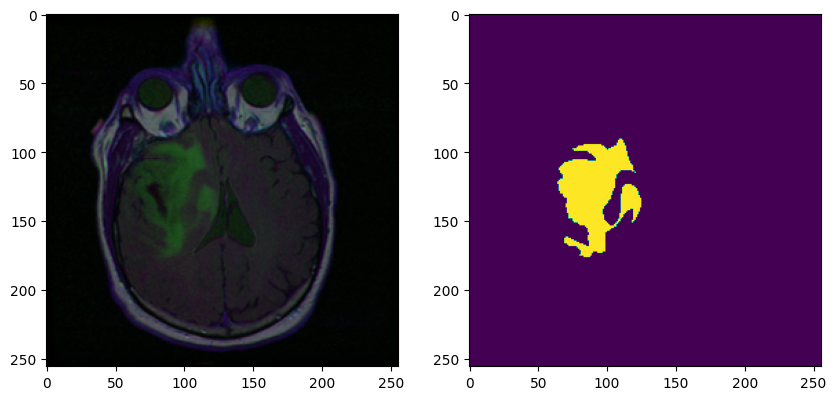

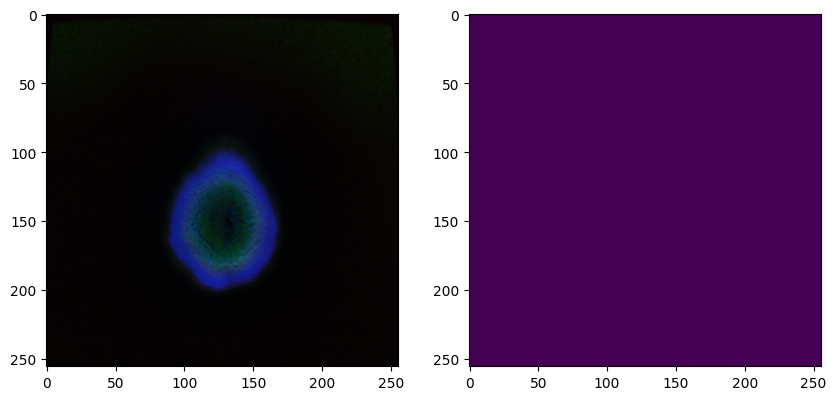

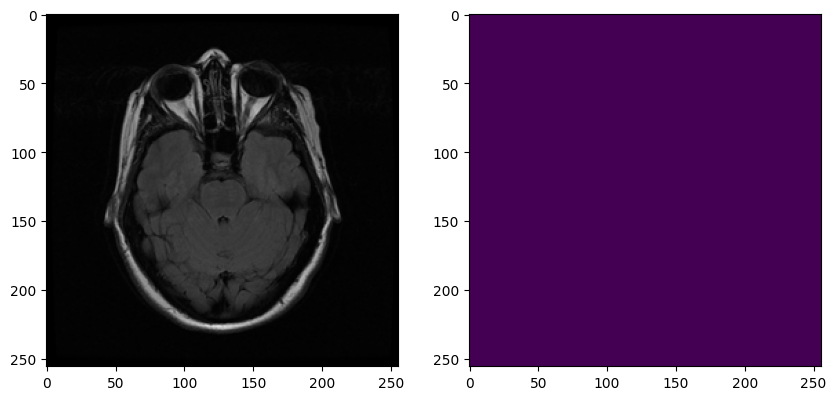

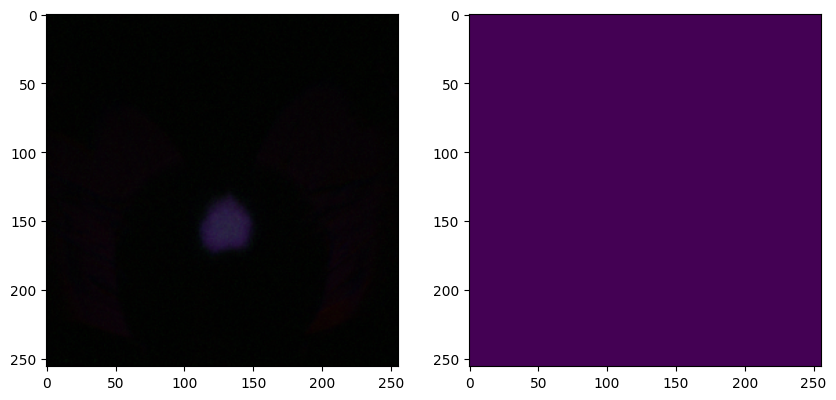

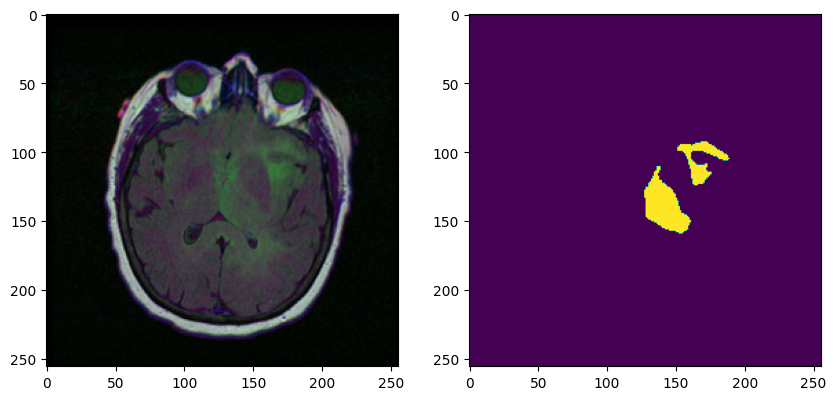

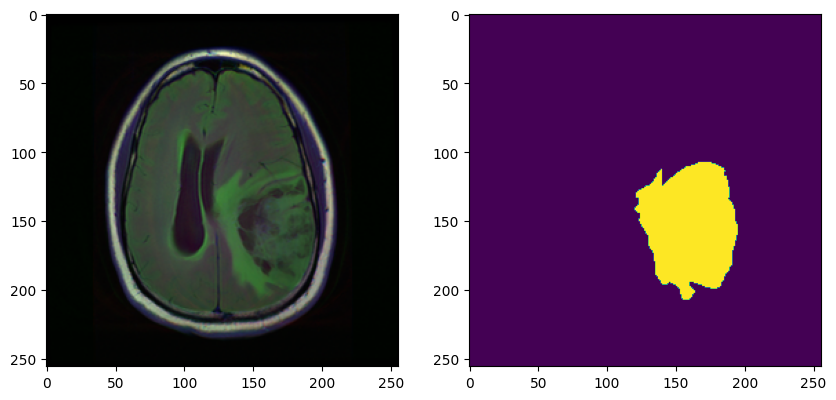

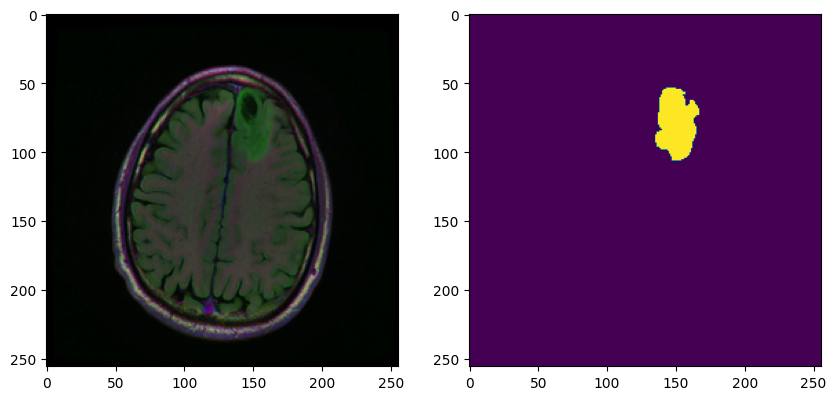

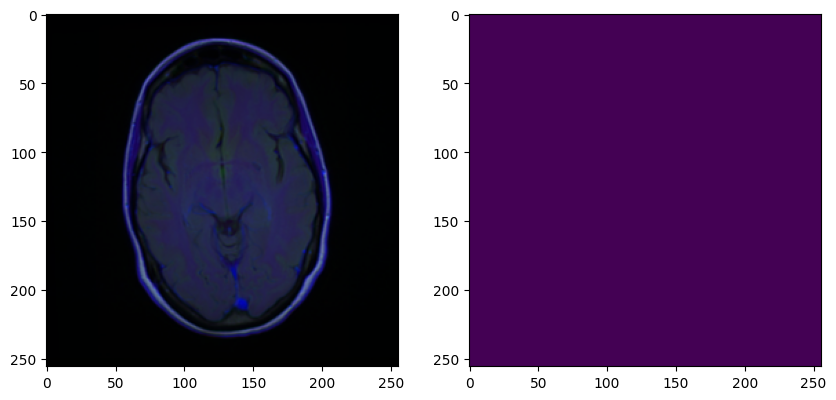

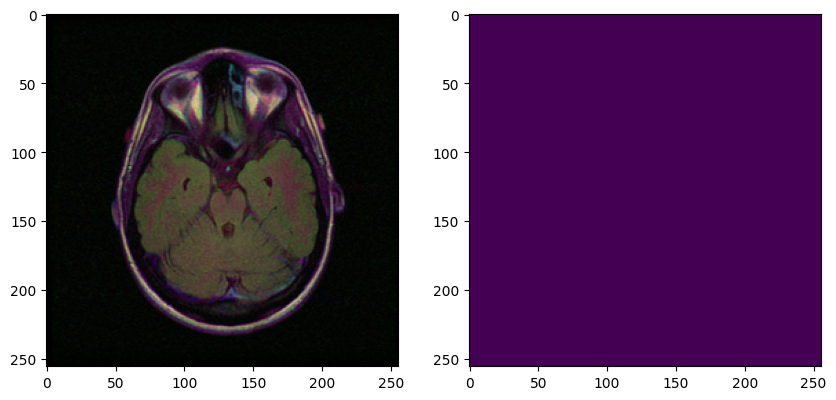

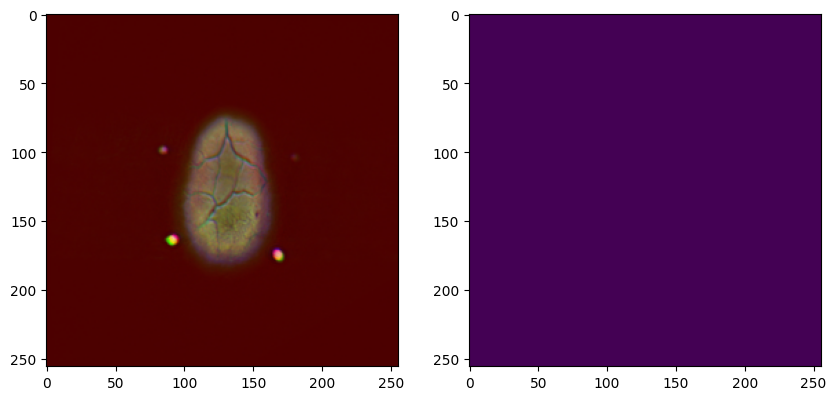

In [4]:
index = np.arange(train_df.shape[0])
rng = np.random.default_rng(37)
rng.shuffle(index)
for idx in range(10):
    image_path = train_df.iloc[index[idx]]['Image']
    mask_path = train_df.iloc[index[idx]]['Mask']
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(mask)

### Training the Model

Encoder and Decoder model with BCELoss

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv_block(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)
        self.decoder1 = self.conv_block(128, 64)

        # Output
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        # Decoding path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Output
        output = self.output_conv(dec1)
        output = self.sigmoid(output)

        return output

# Check available CUDA devices
if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA device {i}: {torch.cuda.get_device_name(i)}")

# Update device assignment
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = UNet(3, 1).float().to(device)




Number of available GPUs: 1
CUDA device 0: Tesla P100-PCIE-16GB


In [6]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        img = np.array(img)
        mask = np.array(mask)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask


# Transform
transform = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.ToTensor()
])



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Loss: 0.2833



  0%|          | 1/500 [01:29<12:22:36, 89.29s/it]

Dev Loss: 0.1915
Epoch 2/500, Loss: 0.0336



  0%|          | 2/500 [02:55<12:04:01, 87.23s/it]

Dev Loss: 0.0313
Epoch 3/500, Loss: 0.0249



  1%|          | 3/500 [04:21<11:58:52, 86.79s/it]

Dev Loss: 0.0279
Epoch 4/500, Loss: 0.0240



  1%|          | 4/500 [05:47<11:55:22, 86.54s/it]

Dev Loss: 0.0264
Epoch 5/500, Loss: 0.0231



  1%|          | 5/500 [07:13<11:52:11, 86.33s/it]

Dev Loss: 0.0250
Epoch 6/500, Loss: 0.0221



  1%|          | 6/500 [08:39<11:49:05, 86.12s/it]

Dev Loss: 0.0248
Epoch 7/500, Loss: 0.0198



  1%|▏         | 7/500 [10:05<11:47:26, 86.10s/it]

Dev Loss: 0.0197
Epoch 8/500, Loss: 0.0190



  2%|▏         | 8/500 [11:31<11:45:48, 86.07s/it]

Dev Loss: 0.0211
Epoch 9/500, Loss: 0.0178



  2%|▏         | 9/500 [12:57<11:44:09, 86.05s/it]

Dev Loss: 0.0193
Epoch 10/500, Loss: 0.0150



  2%|▏         | 10/500 [14:23<11:42:52, 86.07s/it]

Dev Loss: 0.0162
Epoch 11/500, Loss: 0.0140



  2%|▏         | 11/500 [15:49<11:41:09, 86.03s/it]

Dev Loss: 0.0144
Epoch 12/500, Loss: 0.0130



  2%|▏         | 12/500 [17:15<11:39:26, 86.00s/it]

Dev Loss: 0.0163
Epoch 13/500, Loss: 0.0128



  3%|▎         | 13/500 [18:41<11:37:45, 85.97s/it]

Dev Loss: 0.0138
Epoch 14/500, Loss: 0.0121



  3%|▎         | 14/500 [20:06<11:35:41, 85.89s/it]

Dev Loss: 0.0121
Epoch 15/500, Loss: 0.0107



  3%|▎         | 15/500 [21:32<11:34:07, 85.87s/it]

Dev Loss: 0.0106
Epoch 16/500, Loss: 0.0093



  3%|▎         | 16/500 [22:58<11:32:14, 85.82s/it]

Dev Loss: 0.0107
Epoch 17/500, Loss: 0.0097



  3%|▎         | 17/500 [24:24<11:31:08, 85.86s/it]

Dev Loss: 0.0107
Epoch 18/500, Loss: 0.0092



  4%|▎         | 18/500 [25:50<11:29:23, 85.82s/it]

Dev Loss: 0.0102
Epoch 19/500, Loss: 0.0078



  4%|▍         | 19/500 [27:15<11:28:00, 85.82s/it]

Dev Loss: 0.0096
Epoch 20/500, Loss: 0.0080



  4%|▍         | 20/500 [28:41<11:26:44, 85.84s/it]

Dev Loss: 0.0099
Epoch 21/500, Loss: 0.0085



  4%|▍         | 21/500 [30:07<11:25:15, 85.84s/it]

Dev Loss: 0.0087
Epoch 22/500, Loss: 0.0067



  4%|▍         | 22/500 [31:33<11:23:31, 85.80s/it]

Dev Loss: 0.0093
Epoch 23/500, Loss: 0.0066



  5%|▍         | 23/500 [32:58<11:21:43, 85.75s/it]

Dev Loss: 0.0078
Epoch 24/500, Loss: 0.0065



  5%|▍         | 24/500 [34:24<11:20:15, 85.75s/it]

Dev Loss: 0.0103
Epoch 25/500, Loss: 0.0063



  5%|▌         | 25/500 [35:50<11:19:21, 85.81s/it]

Dev Loss: 0.0073
Epoch 26/500, Loss: 0.0061



  5%|▌         | 26/500 [37:16<11:18:12, 85.85s/it]

Dev Loss: 0.0075
Epoch 27/500, Loss: 0.0055



  5%|▌         | 27/500 [38:42<11:16:37, 85.83s/it]

Dev Loss: 0.0069
Epoch 28/500, Loss: 0.0050



  6%|▌         | 28/500 [40:07<11:14:40, 85.76s/it]

Dev Loss: 0.0067
Epoch 29/500, Loss: 0.0050



  6%|▌         | 29/500 [41:33<11:13:37, 85.81s/it]

Dev Loss: 0.0069
Epoch 30/500, Loss: 0.0048



  6%|▌         | 30/500 [42:59<11:12:43, 85.88s/it]

Dev Loss: 0.0067
Epoch 31/500, Loss: 0.0063



  6%|▌         | 31/500 [44:25<11:10:50, 85.82s/it]

Dev Loss: 0.0080
Epoch 32/500, Loss: 0.0060



  6%|▋         | 32/500 [45:51<11:09:19, 85.81s/it]

Dev Loss: 0.0073
Epoch 33/500, Loss: 0.0049



  7%|▋         | 33/500 [47:17<11:08:12, 85.85s/it]

Dev Loss: 0.0062
Epoch 34/500, Loss: 0.0051



  7%|▋         | 34/500 [48:43<11:06:42, 85.84s/it]

Dev Loss: 0.0064
Epoch 35/500, Loss: 0.0048



  7%|▋         | 35/500 [50:09<11:05:22, 85.86s/it]

Dev Loss: 0.0063
Epoch 36/500, Loss: 0.0050



  7%|▋         | 36/500 [51:34<11:03:30, 85.80s/it]

Dev Loss: 0.0067
Epoch 37/500, Loss: 0.0047



  7%|▋         | 37/500 [53:00<11:02:01, 85.79s/it]

Dev Loss: 0.0063
Epoch 38/500, Loss: 0.0041



  8%|▊         | 38/500 [54:25<10:59:58, 85.71s/it]

Dev Loss: 0.0067
Epoch 39/500, Loss: 0.0040



  8%|▊         | 39/500 [55:51<10:58:51, 85.75s/it]

Dev Loss: 0.0061
Epoch 40/500, Loss: 0.0038



  8%|▊         | 40/500 [57:17<10:58:06, 85.84s/it]

Dev Loss: 0.0060
Epoch 41/500, Loss: 0.0040



  8%|▊         | 41/500 [58:43<10:56:24, 85.80s/it]

Dev Loss: 0.0058
Epoch 42/500, Loss: 0.0036



  8%|▊         | 42/500 [1:00:09<10:54:09, 85.70s/it]

Dev Loss: 0.0061
Epoch 43/500, Loss: 0.0036



  9%|▊         | 43/500 [1:01:34<10:53:03, 85.74s/it]

Dev Loss: 0.0063
Epoch 44/500, Loss: 0.0036



  9%|▉         | 44/500 [1:03:00<10:50:48, 85.63s/it]

Dev Loss: 0.0057
Epoch 45/500, Loss: 0.0034



  9%|▉         | 45/500 [1:04:26<10:49:46, 85.68s/it]

Dev Loss: 0.0067
Epoch 46/500, Loss: 0.0035



  9%|▉         | 46/500 [1:05:52<10:49:01, 85.77s/it]

Dev Loss: 0.0094
Epoch 47/500, Loss: 0.0039



  9%|▉         | 47/500 [1:07:17<10:46:42, 85.66s/it]

Dev Loss: 0.0061
Epoch 48/500, Loss: 0.0038



 10%|▉         | 48/500 [1:08:42<10:44:28, 85.55s/it]

Dev Loss: 0.0062
Epoch 49/500, Loss: 0.0038



 10%|▉         | 49/500 [1:10:08<10:43:19, 85.59s/it]

Dev Loss: 0.0059
Epoch 50/500, Loss: 0.0035



 10%|█         | 50/500 [1:11:34<10:42:16, 85.64s/it]

Dev Loss: 0.0057
Epoch 51/500, Loss: 0.0031



 10%|█         | 51/500 [1:12:59<10:40:54, 85.65s/it]

Dev Loss: 0.0065
Epoch 52/500, Loss: 0.0030



 10%|█         | 52/500 [1:14:25<10:40:12, 85.74s/it]

Dev Loss: 0.0061
Epoch 53/500, Loss: 0.0029



 11%|█         | 53/500 [1:15:51<10:38:35, 85.72s/it]

Dev Loss: 0.0060
Epoch 54/500, Loss: 0.0028



 11%|█         | 54/500 [1:17:17<10:37:34, 85.77s/it]

Dev Loss: 0.0063
Epoch 55/500, Loss: 0.0028



 11%|█         | 55/500 [1:18:43<10:35:58, 85.75s/it]

Dev Loss: 0.0058
Epoch 56/500, Loss: 0.0028



 11%|█         | 56/500 [1:20:09<10:35:14, 85.84s/it]

Dev Loss: 0.0064
Epoch 57/500, Loss: 0.0028



 11%|█▏        | 57/500 [1:21:34<10:33:22, 85.78s/it]

Dev Loss: 0.0070
Epoch 58/500, Loss: 0.0081



 12%|█▏        | 58/500 [1:23:00<10:31:55, 85.78s/it]

Dev Loss: 0.0121
Epoch 59/500, Loss: 0.0066



 12%|█▏        | 59/500 [1:24:26<10:30:10, 85.74s/it]

Dev Loss: 0.0077
Epoch 60/500, Loss: 0.0042



 12%|█▏        | 60/500 [1:25:51<10:28:38, 85.72s/it]

Dev Loss: 0.0068
Epoch 61/500, Loss: 0.0031



 12%|█▏        | 61/500 [1:27:17<10:26:33, 85.63s/it]

Dev Loss: 0.0062
Epoch 62/500, Loss: 0.0027



 12%|█▏        | 62/500 [1:28:42<10:24:50, 85.59s/it]

Dev Loss: 0.0064
Epoch 63/500, Loss: 0.0027



 13%|█▎        | 63/500 [1:30:08<10:23:47, 85.65s/it]

Dev Loss: 0.0067
Epoch 64/500, Loss: 0.0025



 13%|█▎        | 64/500 [1:31:34<10:22:37, 85.68s/it]

Dev Loss: 0.0064
Epoch 65/500, Loss: 0.0024



 13%|█▎        | 64/500 [1:33:00<10:33:34, 87.19s/it]

Dev Loss: 0.0068
Early stopping after 65 epochs.


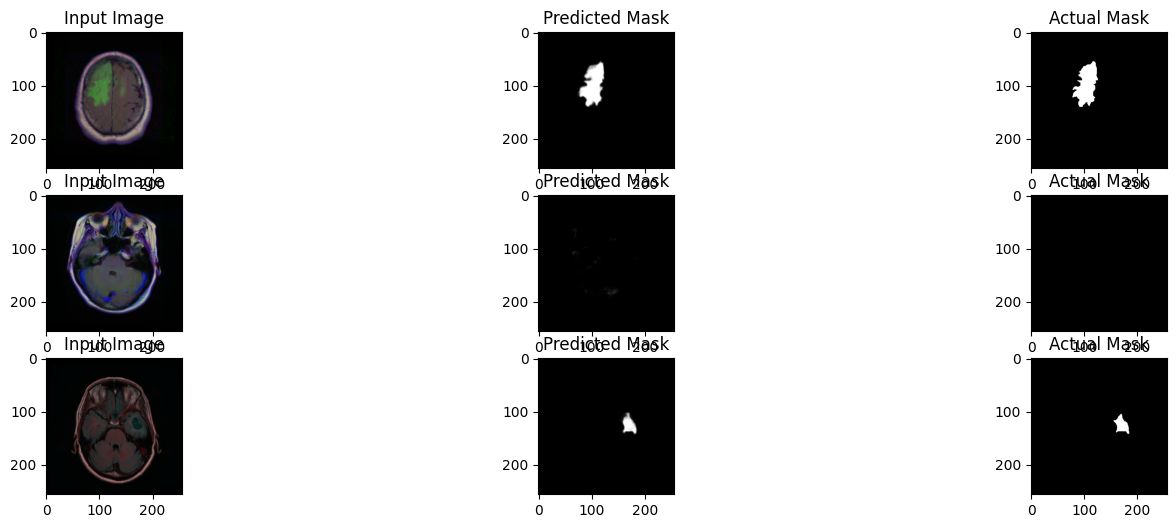

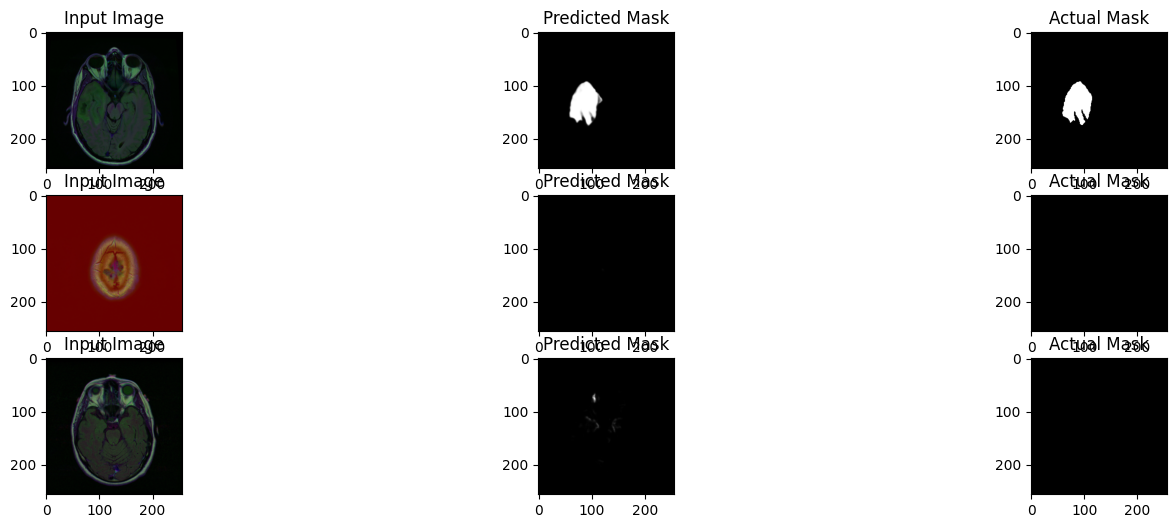

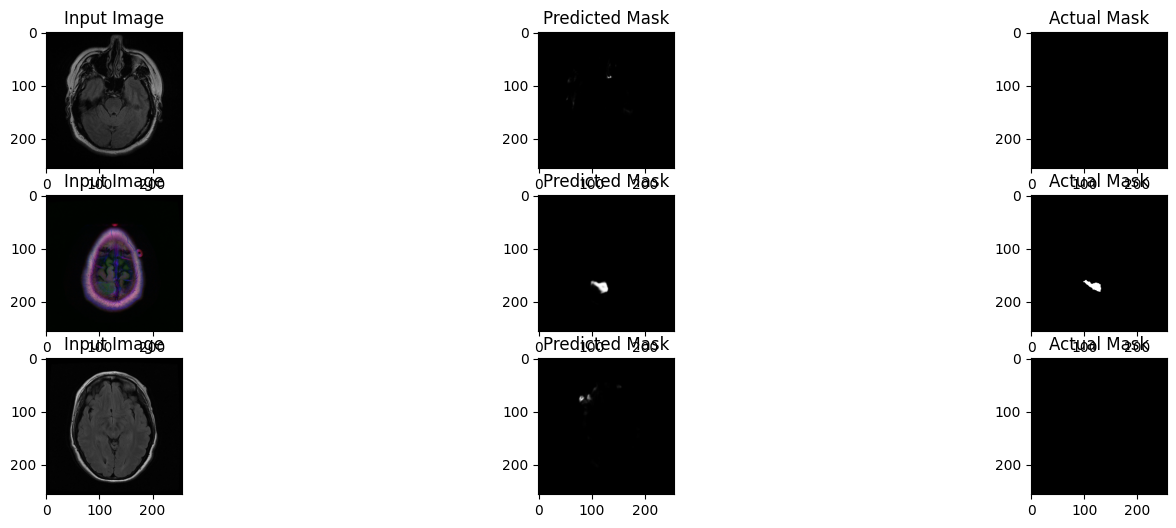

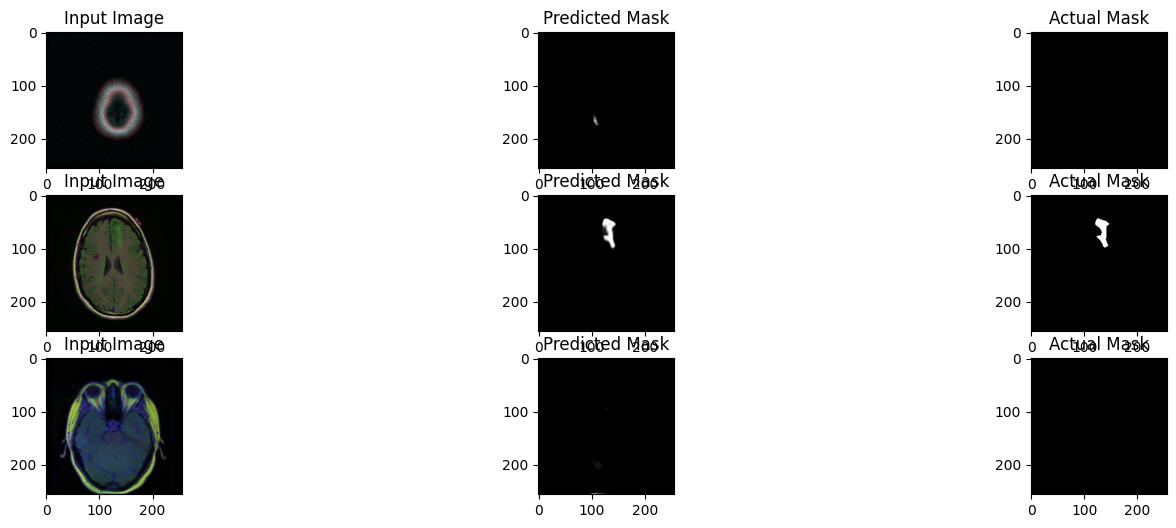

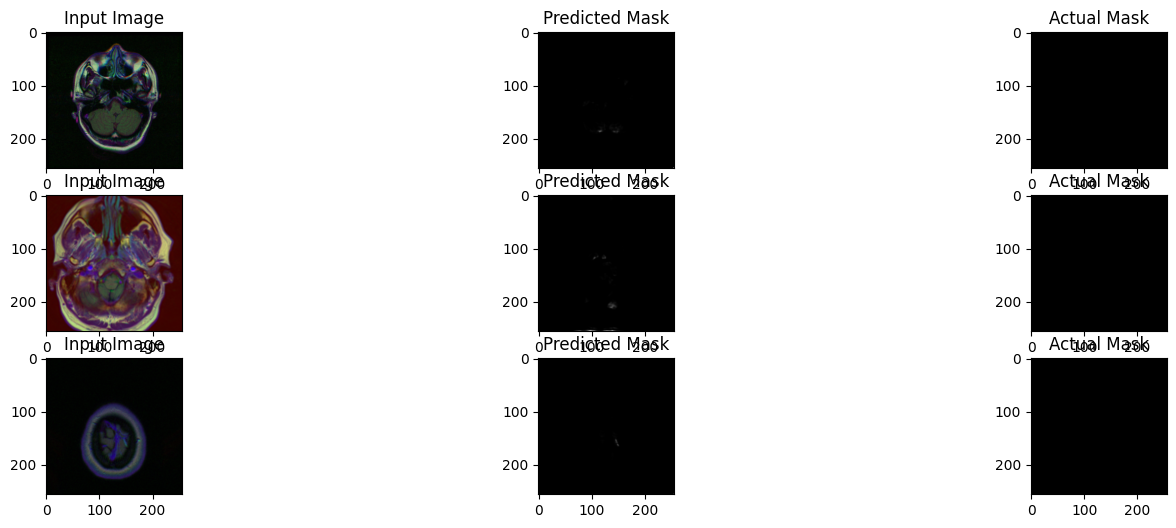

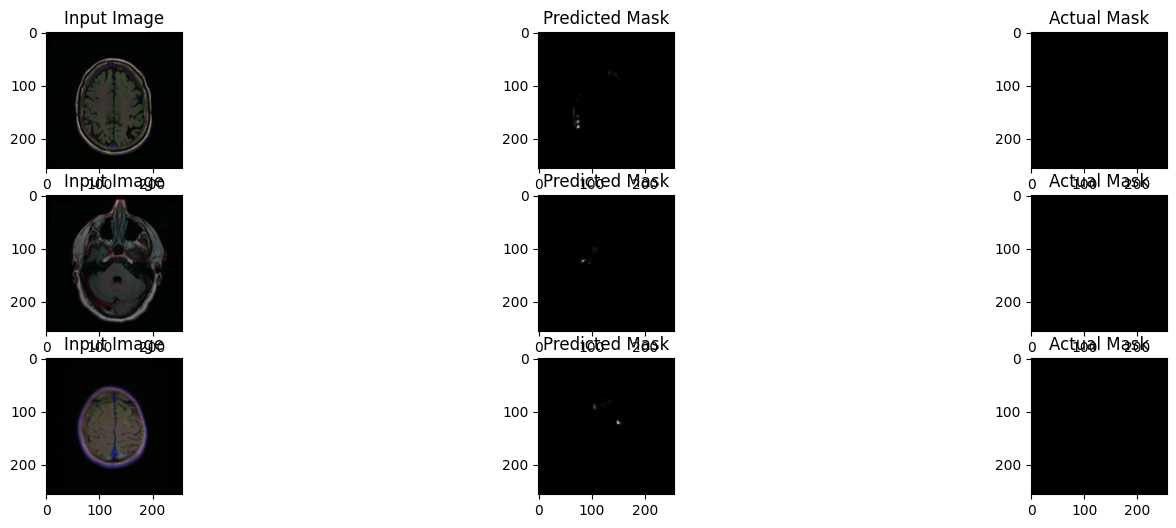

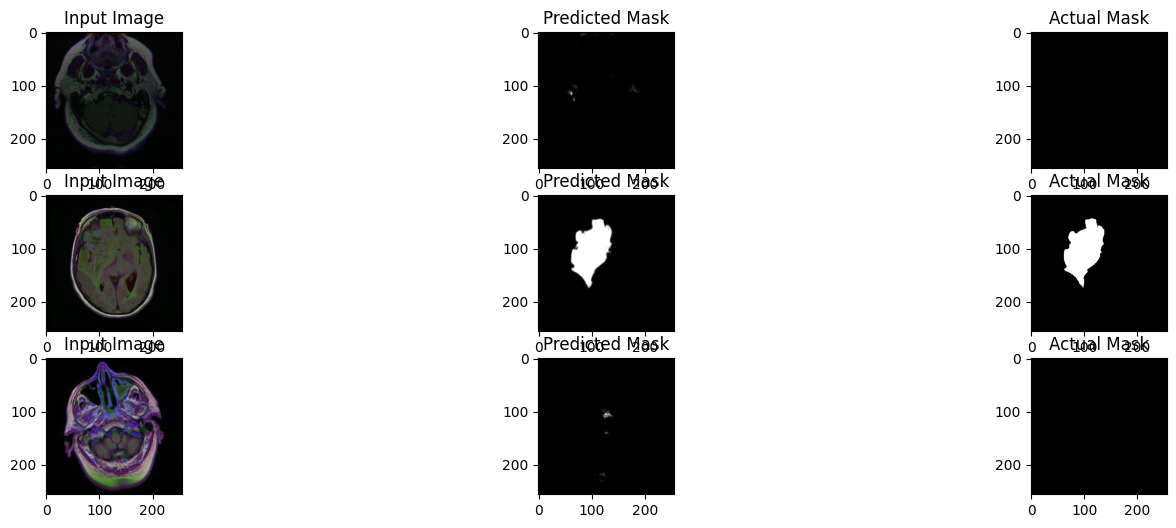

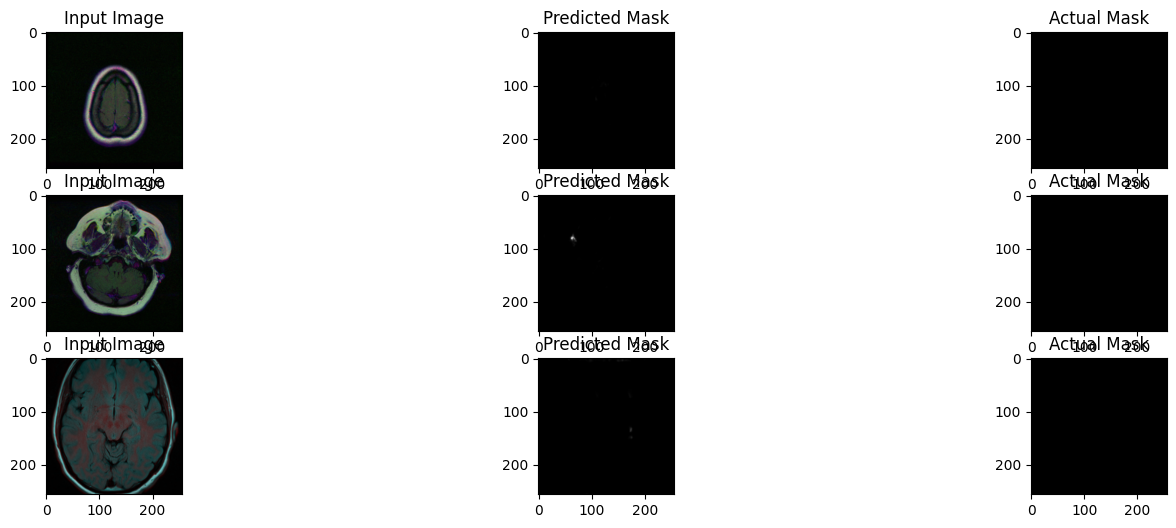

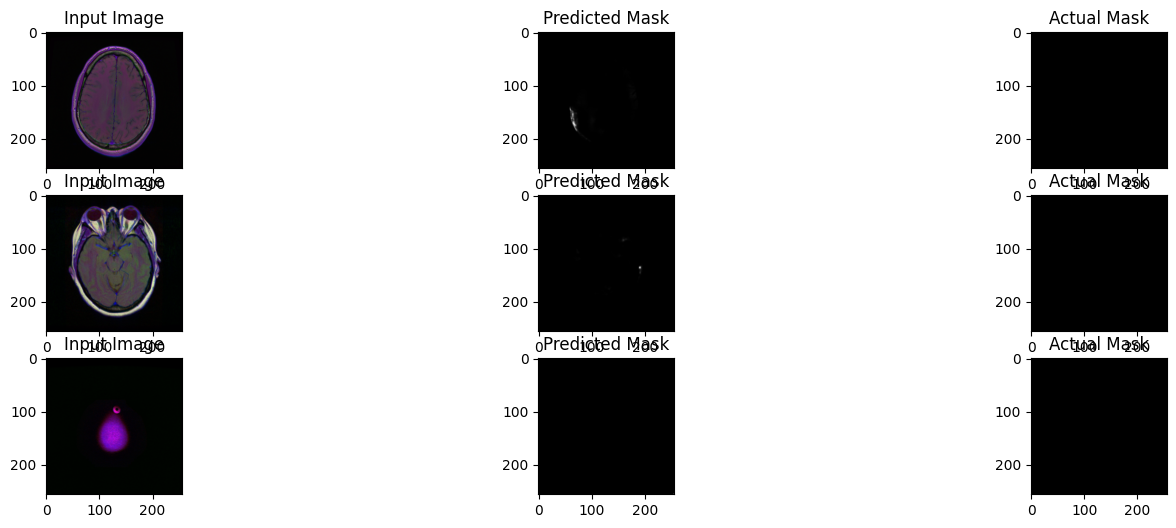

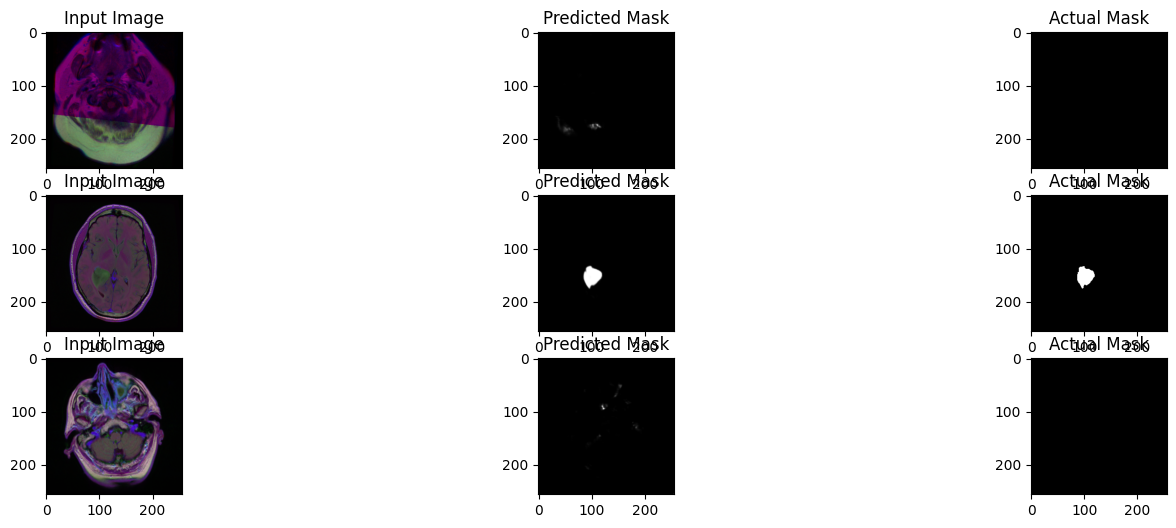

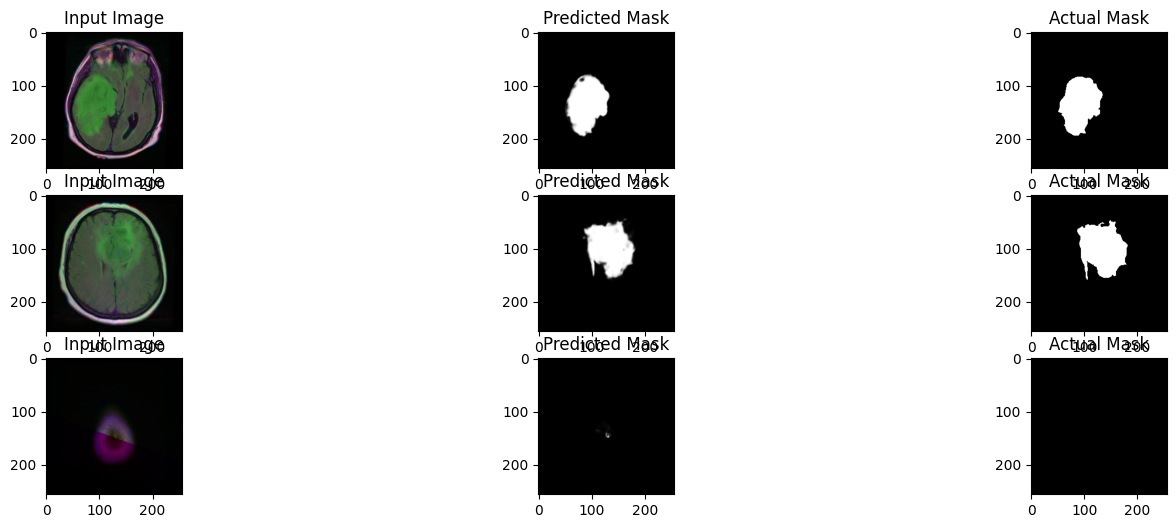

In [7]:
from tqdm import tqdm
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training loop
def train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=10, patience=15):
    model.train()
    best_dev_loss = np.inf
    early_stopping_counter = 0
    patience = patience
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for images, masks in dataloader:
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        model.eval()
        dev_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(dev_dataloader, desc='Evaluating on dev set', unit='batch'):
                images = images.float().to(device)
                masks = masks.float().to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                dev_loss += loss.item() * images.size(0)

        dev_loss = dev_loss / len(dev_dataloader.dataset)
        print(f'Dev Loss: {dev_loss:.4f}')
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), f'model_{epoch+1}.pth')

        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                torch.save(model.state_dict(), 'final_model.pth')
                break

def evaluate(model, dataloader):
    model.eval()
    with torch.no_grad():
        counter = 0
        for images, masks in dataloader:
            if counter > 10:
                break
            counter += 1
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Forward pass
            outputs = model(images)

            # Plot the results for visualization
            plt.figure(figsize=(18, 6))
            for i in range(min(len(images), 3)):
                plt.subplot(3, 3, i*3 + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                plt.title('Input Image')

                plt.subplot(3, 3, i*3 + 2)
                plt.imshow(outputs[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Predicted Mask')

                plt.subplot(3, 3, i*3 + 3)
                plt.imshow(masks[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Actual Mask')

            plt.show()


image_paths = train_df['Image'].values.tolist()
mask_paths = train_df['Mask'].values.tolist()

dev_paths = val_df['Image'].values.tolist()
dev_mask_paths = val_df['Mask'].values.tolist()
dataset = SegmentationDataset(image_paths, mask_paths, transform=transform)
dev_dataset = SegmentationDataset(dev_paths, dev_mask_paths, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
# Training
train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500)

# Evaluation
evaluate(model, dataloader)


### Evaluating the performance

This section evaluates our model's segmentation performance using two common metrics: Intersection over Union (IoU) and Dice coefficient (Dice). Both metrics quantify the overlap between predicted and ground truth segmentation masks.

IoU focuses on the ratio of correctly classified pixels, while Dice emphasizes the balance between true positives and both false positives and negatives. We'll calculate these scores to assess the model's segmentation accuracy.

In [8]:
import torch

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)
    #print(dice)
    return dice


In [9]:
def eval_model(model, test_loader, device):
    model.eval()
    ious = []
    dices = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.float().to(device)
            masks = masks.float().to(device)
            outputs = model(images)
            
            outputs[outputs < .5] = 0
            outputs[outputs > .5] = 1

            iou_score_val = iou_score(outputs, masks)
            dice_score_val = dice_score(outputs, masks)

            ious.append(iou_score_val)
            dices.append(dice_score_val)

    mean_iou = sum(ious) / len(ious)
    mean_dice = sum(dices) / len(dices)

    return mean_iou, mean_dice

In [10]:
test_dataset = SegmentationDataset(test_df[test_df['Diagnosis'] == 1]['Image'].values.tolist(), test_df[test_df['Diagnosis'] == 1]['Mask'].values.tolist(), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_model(model, test_dataloader, device)

(tensor(0.8538, device='cuda:0'), tensor(0.9210, device='cuda:0'))

In [11]:
torch.save(model.state_dict(), 'baseline_ckpt.pth')

In [12]:
model.load_state_dict(torch.load('baseline_ckpt.pth'))

<ipython-input-12-416895099476>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('baseline_ckpt.pth'))


<All keys matched successfully>